Text Analysis
==
This project is a text analysis of the r/survivor subreddit's opinion on each Survivor season. The goal of this visualization is to identify main descriptors for each season. Text analysis inspired by [github/walkerkq](https://github.com/walkerkq/textmining_southpark/)

All data sourced from [r/survivor](https://www.reddit.com/r/survivor/)

## ----------------------------------------- Reading the Data -----------------------------------------

### Connect to Reddit API
Establish connection to Reddit via the Python Reddit API Wrapper

In [7]:
import praw
import re
import pandas as pd
from praw.models import MoreComments
import numpy as np
from datetime import datetime, timezone
import json

# Track date of data pull
pull_date = datetime.now().strftime("%b %d %Y %H:%M:%S")

# Create connection to Reddit via PRAW
fp = open('./settings.json')
settings = json.load(fp).get('praw')
reddit = praw.Reddit(client_id = settings.get('client_id'),
                    client_secret = settings.get('client_secret'),
                    user_agent = settings.get('user_agent'),
                    username = settings.get('username'),
                    password = settings.get('password'))
subreddit = reddit.subreddit('survivor')

fp = open('./seasons.json')
seasons = json.load(fp)

readData = False
processTopPosts = False

### Get Reddit Submission IDs
Get the reddit ID of all posts to be analyzed

In [ ]:
# Get top 100 submissions on each season
if(processTopPosts):
    top_submissions = {}
    for (nbr, season) in seasons.items():
        submissions = subreddit.search("flair:"+season.replace("\n"," "),sort='top')
        for sub in submissions:
            top_submissions[sub.id] = nbr

# Unspoiled posts
wssyw_ids = ['10tpq9', # e.g. S06: The Amazon, hyperlinked
             '26viy4', # e.g. Season 28: Cagayan
             '37c7zu', # e.g. S15: China
             '3xp433', 
             '4kzd4g', 
             '5jwzib', 
             '6ga0ty', # [Season 7: Pearl Islands](link to countdown)
             '8p0ye9', 
             'btu8iu'  # Note: Still posting countdown
            ]
wssyw_spoilers = {'1':'c48snf',
                  '2':'c0mplt',
                  '3':'c1c9cs',
                  '4':'c1r9tn',
                  '5':'bwr435',
                  '6':'c3slsk',
                  '7':'c8c3ov',
                  '8':'bx4u7z',
                  '9':'c2jn8g',
                  '10':'c24mgl',
                  '11':'c0ep8t',
                  '12':'c5xgnr',
                  '13':'c12yug',
                  '14':'by9sit',
                  '15':'c8bzdu',
                  '16':'c6b0ce',
                  '17':'c5pfk8',
                  '18':'c8c1g8',
                  '19':'bymej8',
                  '20':'c82s4d',
                  '21':'bztmw5',
                  '22':'bv9dna',
                  '23':'bzequv',
                  '24':'bwee06',
                  '25':'c6bmtt'}

In [ ]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

### Functions to extract data
Define functions that will help get the reddit comment tree as a dataframe

In [ ]:
# Create dataframe of all comments
def get_reply_comments(submission):
    d = []
    for top_level_comment in submission.comments:
        if (not top_level_comment.is_submitter):
            continue    
        season = None
        season_name = None
        match1 = re.search("(\d+:( (\w|-)+|\.+){1,})",top_level_comment.body)
        match2 = re.search("(:(\d+)( (\w|-)+|\.+){1,})",top_level_comment.body) # Data error of S:00 Example Name
        if match1:
            season = int(match1.group(0).split(': ')[0])
            season_name = seasons[str(season)]
        if match2:
            season = int(match2.group().split(':')[1].split(' ')[0])
            season_name = seasons[str(season)]
        for comment in top_level_comment.replies.list():
            d.append({'season_nbr':season,'season':season_name,'comment_id':comment.id,'comment':comment.body,'score':comment.score})
    return d

# Get comments for each WSSYW Countdown submission
def getComments(r_id, top_level_comment=False, season_key=0):
    d = []
    submission = reddit.submission(id=r_id)
    submission.comments.replace_more(limit=2500, threshold=0)
    if top_level_comment:
        [d.append(row) for row in get_reply_comments(submission)]
    else:
        for comment in submission.comments.list():
            d.append({'season_nbr':int(season_key),'season':seasons[season_key],'comment_id':comment.id,'comment':comment.body,'score':comment.score})
    return d

### Read data from Reddit

In [ ]:
if (readData):
    #### LARGE DATA SET ####
    if (processTopPosts):
        d_all = []
        for (r_id,season_nbr) in top_submissions.items():
            [d_all.append(row) for row in getComments(r_id,False,season_nbr)]
        df_raw_all = pd.DataFrame(d_all)

        # Save csv for reference
        df_raw_all.to_csv('./data/top_post_comments.csv',index = None, header=True)

    #### UNSPOILED DATA ####
    d=[]
    for r_id in wssyw_ids:
        [d.append(row) for row in getComments(r_id, True)]

    df_raw_wssyw = pd.DataFrame(d)

    # Save csv for reference
    df_raw_wssyw.to_csv('./data/unspoiled_comments.csv',index = None, header=True)

### Create dataframe based on results of reading data

In [8]:
csv_to_read = "./data/unspoiled_comments.csv"

df_raw = pd.read_csv(csv_to_read)
df_raw_clean = df_raw[df_raw['score']>0]

In [ ]:
from nltk.tokenize import sent_tokenize
from collections import OrderedDict

s = "'' think deserve mention breath ri caramoan ."
t = sent_tokenize(s)
seen = set()
print([len(word_tokenize(sent)) for sent in t])
print( [x for x in t if (x not in seen and not seen.add(x)) or (len(word_tokenize(x))<4)])

## ----------------------------------------- Sentiment Analysis -----------------------------------------

In [147]:
sentiment_data = df_raw[['season','season_nbr','comment','score']]
sentiment_data['polarity'] = sentiment_data.comment.apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_data['subjectivity'] = sentiment_data.comment.apply(lambda x: TextBlob(x).sentiment.subjectivity)
sentiment_data.drop(columns=['comment']).to_csv('./data/season_comments_sentiment.csv',index = None, header=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    5836.000000
mean        0.158460
std         0.259092
min        -1.000000
25%         0.000000
50%         0.163976
75%         0.301731
max         1.000000
Name: polarity, dtype: float64


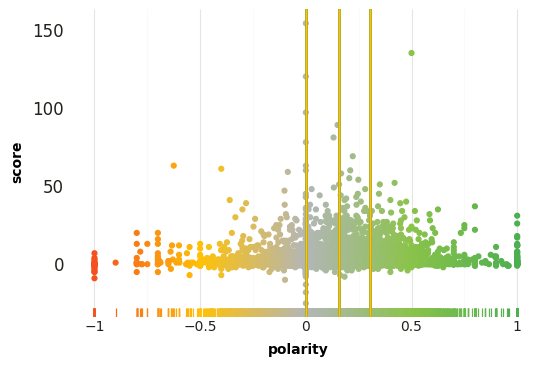

<ggplot: (-9223372036416884038)>

In [148]:
ma = sentiment_data.score.max()/10
mi = sentiment_data.score.min()/10
# sentiment_data.boxplot(column=['weighted'])
print(sentiment_data.polarity.describe())
# sentiment_data.plot(kind='scatter',x='sentiment',y='score',color='red')
mean = sentiment_data.polarity.mean()
q1 = sentiment_data.polarity.quantile(.25)
q3 = sentiment_data.polarity.quantile(.75)
p = ggplot(aes(x='polarity', y='score', color='polarity'), sentiment_data) 
p + geom_point() + geom_rug(sides="b") + geom_vline(aes(xintercept = mean, color='polarity')) + geom_vline(aes(xintercept = q1, color='polarity')) + geom_vline(aes(xintercept = q3, color='polarity')) + xlim(-1, 1) + scale_color_gradientn(["#F4511E","#FFC107","#B3B6B7","#8BC34A","#4CAF50"]) + my_theme + theme(figure_size = (6,4))

## ----------------------------------------- Cleaning the Data -----------------------------------------

### Clean data

In [18]:
# stop = ['i', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
#         "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
#         'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
#         'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 
#         'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'a', 'an', 'the', 'because', 
#         'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
#         'during', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
#         'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',  'some', 'such',  's', 't', 
#         'will', 'just', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain']
stop = ['be']
from textblob import Word
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize

fp = open('./contractions.json')
contractions = json.load(fp)
lem = WordNetLemmatizer() 

def get_wordnet_pos(sent):
    """Map POS tag to first character lemmatize() accepts"""
    sent_pos = []
    tags = pos_tag(word_tokenize(sent))
    for tag in tags:
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        sent_pos += [tag_dict.get(tag[1][0], wordnet.NOUN)]
    return sent_pos

def remove_copy_paste(x):
    sentences = sent_tokenize(x)
    seen = set()
    return " ".join([sent for sent in sentences if (sent not in seen and not seen.add(sent)) or (len(word_tokenize(sent))<8)])
def to_lower(x):
    return " ".join(x.lower() for x in x.split())
def remove_stop(x):
    return " ".join(word for word in x.split() if word not in stop)
def lem_words(x):
    contr = " ".join([contractions.get(word.replace("'",''), word.replace("'",'')) for word in x.split()])
    pos = get_wordnet_pos(contr)
    lems = []
    for w,p in zip(word_tokenize(contr), pos):
        lems+=[lem.lemmatize(w, p)]
    return " ".join(lems)

df_clean_tmp = df_raw_clean
col = df_raw_clean['comment'].apply(lambda x: to_lower(x)).apply(lambda x: lem_words(x)).str.replace('[^\w\s]|[\d]','').apply(lambda x: remove_stop(x))
df_clean_tmp = df_raw_clean.assign(comment_clean=col.values)

### Combine cleaned data into one row for each season

In [19]:
df_comb = pd.DataFrame(columns = ['comment'])

df_comb['comment'] = df_clean_tmp.groupby('season_nbr')['comment_clean'].apply(lambda x: " ".join(x))
df_comb['season_nbr'] = df_comb.index

df_clean = df_comb

### Get list of proper nouns based on sentence structure of raw data

In [20]:
import spacy
from spacy.lang.en import English

from nltk import ne_chunk, pos_tag, word_tokenize

def getPropNouns(data):
    chunks = ne_chunk(pos_tag(word_tokenize(data)))
    nouns = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            if(chunk.label()=="PERSON"):
                nouns+=[chunk[0][0].lower()]
    return nouns

def getIgnoreWords(data):
    tags = pos_tag(word_tokenize(data))
    tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}
    words = []
    for tag in tags:
        if (tag_dict.get(tag[1][0], wordnet.NOUN) != wordnet.NOUN):
           words+=[tag[0].lower()]
    return words
        
non_nouns = getIgnoreWords(" ".join(df_raw['comment']))

propNounsTemp = {}
df_raw['entity'] = df_raw['comment'].apply(lambda x: getPropNouns(x))
for row in df_raw['entity']:
    for item in row:
        propNounsTemp[item] = propNounsTemp.get(item, 0) + 1

In [21]:
propNouns=[]
for (key, count) in propNounsTemp.items():
    if count > 3:
        propNouns+=[key]
# print([word for word in propNouns if pos_tag([word])[0][1][0] in ['N']])
propNouns = [word for word in propNouns if word not in non_nouns]

In [22]:
rare_words = pd.Series(' '.join(df_clean['comment']).split()).value_counts()[pd.Series(' '.join(df_clean['comment']).split()).value_counts()<=1].index.values.tolist()
freq_words = pd.Series(' '.join(df_clean['comment']).split()).value_counts()[:100].index.values.tolist()

## ----------------------------------- Determine Characteristic Words -----------------------------------

### Calculate the characteristic-ness of a word to a season
Calculate the tf-idf values to determine how characteristic a word/phrase is to a given season

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.corpus import stopwords

drop_terms = rare_words + [word.replace(' ','') for word in stopwords.words('english')]
# vec = CountVectorizer(ngram_range=(1,4), analyzer='word')
vec = TfidfVectorizer(ngram_range=(1,3), analyzer='word', max_df=0.99)
X = vec.fit_transform(df_clean['comment'])
df_tmp = pd.DataFrame(X.toarray(), index=df_clean['season_nbr'] ,columns=vec.get_feature_names())
tdm = pd.DataFrame(df_tmp.transpose())
tdm = tdm[~tdm.index.isin(drop_terms)]
tdm.index.name = 'word'
tdm['sum'] = tdm.sum(axis=1)
tdm = tdm[~tdm.index.isin(tdm.sort_values(24.0, ascending=False)[:26][tdm[24.0]==tdm['sum']].index.tolist())]

tdm.sort_values('sum', ascending=False).head(25)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


season_nbr,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,sum
word,,,,,,,,,,,,,,,,,,,,,
twist,0.000969,0.004287,0.034650,0.007491,0.027251,0.024136,0.126159,0.003049,0.006645,0.023096,...,0.014728,0.018602,0.065492,0.012184,0.081415,0.060354,0.074984,0.005029,0.115157,1.519725
favorite,0.012924,0.038115,0.056558,0.019983,0.021746,0.033607,0.029586,0.039106,0.052841,0.063191,...,0.033580,0.019085,0.051280,0.016667,0.020883,0.000000,0.000000,0.025798,0.004726,1.267809
winner,0.005814,0.031434,0.028350,0.004495,0.065100,0.020688,0.018023,0.006098,0.038211,0.049272,...,0.080186,0.021702,0.072386,0.030460,0.037800,0.013928,0.000000,0.005029,0.018425,1.232777
the first,0.065892,0.052867,0.053550,0.062924,0.057530,0.055167,0.024030,0.089951,0.048179,0.012318,...,0.021274,0.031003,0.012064,0.020306,0.023261,0.009285,0.007893,0.000000,0.013819,1.125962
story,0.017442,0.012860,0.006300,0.050939,0.013626,0.010344,0.032441,0.022869,0.051502,0.053891,...,0.039275,0.037203,0.065492,0.040613,0.014538,0.009285,0.007893,0.020116,0.000000,1.098646
know,0.045543,0.018575,0.018900,0.029964,0.025737,0.017240,0.025232,0.045738,0.014952,0.020017,...,0.022910,0.060455,0.022405,0.016245,0.029077,0.018570,0.015786,0.000000,0.018425,1.003976
watch it,0.037791,0.018575,0.022050,0.016480,0.036335,0.024136,0.045657,0.035066,0.033227,0.041573,...,0.022910,0.031003,0.008617,0.006092,0.020354,0.000000,0.015786,0.015087,0.009213,0.967758
island,0.010936,0.005864,0.008080,0.004611,0.013980,0.024763,0.157791,0.012514,0.006818,0.011058,...,0.003358,0.006362,0.007073,0.004167,0.002983,0.000000,0.048589,0.010319,0.000000,0.923886
rank,0.019380,0.021433,0.022050,0.020975,0.019681,0.022412,0.022829,0.028967,0.019936,0.024636,...,0.026183,0.018602,0.027575,0.020306,0.005815,0.004643,0.011840,0.000000,0.004606,0.911533


### Determine sentiment of words in tf-idf

In [24]:
blob = [TextBlob(word) for word in tdm.index.tolist()]
tdm['sentiment'] = [float(b.sentiment.polarity) for b in blob]
tdm['subjective'] = [float(b.sentiment.subjectivity) for b in blob]

### Create ranked dataframe

In [25]:
def df_empty(columns, dtypes, index=None):
    assert len(columns)==len(dtypes)
    df = pd.DataFrame(index=index)
    for c,d in zip(columns, dtypes):
        df[c] = pd.Series(dtype=d)
    return df
ranked = df_empty(columns = ['season','season_name','rank','word','sentiment'],dtypes=[np.float64,np.str,np.float64,np.str,np.str])
for col in tdm.drop(columns=['sentiment','subjective','sum']).columns:
    df_new = df_empty(columns = ['season','season_name','rank','word','sentiment'],dtypes=[np.float64,np.str,np.float64,np.str,np.str])
    df_new['word'] = tdm.sort_values(col, ascending=False).index.tolist()
    df_new['rank'] = df_new.index
    df_new['rank'] = pd.to_numeric(df_new['rank'])
    df_new['season'] = float(col)
    df_new['season_name'] = seasons.get(str(int(col)))
    df_new['sentiment'] = tdm.sort_values(col, ascending=False)['sentiment'].apply(lambda x: 'very positive' if x >= 0.5 else 'positive' if 0.5 > x > 0.15 else 'very negative' if x <= -0.5 else 'negative' if -0.5 < x < -0.05 else 'neutral').tolist()
    ranked = pd.concat([ranked,df_new[:26]])
ranked.to_csv('./data/ranked_words.csv',index = None, header=True)

In [26]:
print(ranked)

    season          season_name  rank            word sentiment
0      1.0               Borneo   0.0          borneo   neutral
1      1.0               Borneo   1.0       different   neutral
2      1.0               Borneo   2.0       the first  positive
3      1.0               Borneo   3.0           order   neutral
4      1.0               Borneo   4.0        in order   neutral
..     ...                  ...   ...             ...       ...
21    38.0  Edge of\nExtinction  21.0        mean for  negative
22    38.0  Edge of\nExtinction  22.0    very bizzare  positive
23    38.0  Edge of\nExtinction  23.0         bizzare   neutral
24    38.0  Edge of\nExtinction  24.0  because it not   neutral
25    38.0  Edge of\nExtinction  25.0       postmerge   neutral

[988 rows x 5 columns]


## ----------------------------------------- Plot the Data -----------------------------------------

In [27]:
from plotnine import *

# Create graphic
# Define colors
color_background = "white"
color_text = "#22211d"

my_theme = (

    # Begin construction of chart
    theme_bw(base_size=15) +

    # Format background colors
    theme(panel_background = element_rect(fill=color_background, color=color_background)) +
    theme(plot_background  = element_rect(fill=color_background, color=color_background)) +
    theme(panel_border     = element_rect(color=color_background)) +
    theme(strip_background = element_rect(fill=color_background, color=color_background)) +

    # Format the grid
    theme(panel_grid_major_y = element_blank()) +
    theme(panel_grid_minor_y = element_blank()) +
    theme(axis_ticks         = element_blank()) +

    # Format the legend
    theme(legend_position = "none") +

    # Format title and axis labels
    theme(plot_title       = element_text(color=color_text, size=20, weight = "bold")) +
    theme(axis_title_x     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_title_y     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_text_x      = element_text(size=10, vjust=0.5, hjust=0.5, color = color_text)) +
    theme(axis_text_y      = element_text(size=12, color = color_text)) +
    theme(strip_text       = element_text(face = "bold")) +

    # Plot margins
    theme(figure_size = (18,6))
    )

cmap_era = {"1.0":"#F70020",
            "2.0":"#1A7D00",
            "3.0":"#0C96F2",
            "4.0":"#FB9701",
            "5.0":"#636666",
            "6.0":"#87603E",
            "7.0":"#BFBEBB",
            "8.0":"#FB9701",
            "9.0":"#636666",
            "10.0":"#87603E"
           }
cmap_tone = {"very positive":"#4CAF50","positive":"#8BC34A","neutral":"#B3B6B7","negative":"#FFC107","very negative":"#F4511E"}

In [28]:
def base_fig(data, fill_col):
    season_names = pd.Categorical(data['season_name'], categories=data['season_name'].unique().tolist())
    data = data.assign(season_name_ord = season_names)
    return(
        ggplot(data=data, mapping=aes(x='season_name_ord', y='rank')) +
        geom_point(color="black") + 
        geom_label(data=data, 
                   mapping=aes(label='word', fill=fill_col), 
                   color='white',
                   size=10,
                   label_padding=0.15) +
        geom_label(data=data.loc[data['word'].isin(propNouns)], 
           mapping=aes(label='word'), 
           fill='white',
           color='grey',
           size=10,
           label_padding=0.15) +
        scale_y_reverse(limits=[1,25], breaks=range(25,0,-1)) +
        labs(x="Season", y="Ranking",title="Most Characteristic Words Used to Describe a Season") +
        scale_fill_manual(cmap_tone)
    )

In [29]:
first_10 = ranked[ranked['season']<11]
fig1 = (base_fig(first_10, 'sentiment') + my_theme)
ggsave(plot=fig1, filename='./images/seasons1to10.png')

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 18 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./images/seasons1to10.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [30]:
second_10 = ranked[(ranked['season']>10) & (ranked['season']<21)]
fig2 = (base_fig(second_10, 'sentiment') + 
        my_theme  
       )
ggsave(plot=fig2, filename='./images/seasons11to20.png')

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 18 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./images/seasons11to20.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [31]:
third_10 = ranked[(ranked['season']>20) & (ranked['season']<31)]
fig3 = (base_fig(third_10, 'sentiment') + my_theme )
ggsave(plot=fig3, filename='./images/seasons21to30.png')

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 18 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./images/seasons21to30.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [32]:
fourth_10 = ranked[(ranked['season']>30)]
fig4 = (base_fig(fourth_10, 'sentiment') + my_theme )
ggsave(plot=fig4, filename='./images/seasons31to38.png')

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 18 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./images/seasons31to38.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 8 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_label : Removed 8 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
